# Modifying the Target Firmware

To make things easy, we first duplicate the `simpleserial-base/` example to the same directory, rename as `simpleserial-myCustomFirmware/`. Then, we will modify them. Be sure that there is no previous `simpleserial-myCustomFirmware/` file, maded by other users, since it will be overwritten. (Actually, they will be removed.)

https://rtfm.newae.com/Capture/ChipWhisperer-Pro/
https://chipwhisperer.readthedocs.io/en/latest/
https://github.com/newaetech/chipwhisperer

In [1]:
PLATFORM = 'CW308_STM32F4'
CUSTOM_NAME = 'jblfw'
CUSTOM_NAME2 = 'jblfw2'

if PLATFORM == 'CW308_XMEGA' or PLATFORM == 'CWLITEXMEGA':
    HAL = 'xmega'
elif PLATFORM == 'CW308_STM32F4':
    HAL = 'stm32f4'
elif PLATFORM == 'CW308_STM32F3':
    HAL = 'stm32f3'

Next, we are going to change our workspace. To do so, we copy all the releveant things to the current directory.

In [ ]:
%%bash -s "$PLATFORM" "$CUSTOM_NAME" "$CUSTOM_NAME2"
cd $2/$3
make PLATFORM=$1 CRYPTO_TARGET=NONE

# Testing

In [2]:
import chipwhisperer as cw

# connect
scope = cw.scope()
target = cw.target(scope)

Serial baud rate = 38400


In [13]:

# setup
scope.gain.gain = 45
scope.adc.samples = 98119 # increase this to acquire much long trace
scope.adc.offset = 0
scope.adc.basic_mode = 'rising_edge'
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = 'clkgen_x4'
scope.trigger.triggers = 'tio4'
scope.io.tio1 = 'serial_rx'
scope.io.tio2 = 'serial_tx'
scope.io.hs2 = 'clkgen'


In [4]:
# make sure that the baud rate on target side in '*_hal.c', and scope side in 'serial.py' are same as 115200 or 38400
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    target.baud = 115200
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    target.baud = 38400
    prog = cw.programmers.XMEGAProgrammer

Serial baud rate = 115200


In [10]:
fw_path = '%s/%s/simpleserial-base-%s.hex'%(CUSTOM_NAME, CUSTOM_NAME2, PLATFORM) # check your binary file name
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 9611 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 9611 bytes
Serial baud rate = 38400


In [5]:
ktp = cw.ktp.Basic()

In [6]:
key, text = ktp.next()

In [7]:
print(key)
print(text)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'58 4e ed db ae 66 d3 fc c2 5d 9c 76 33 83 14 a2')


In [14]:
trace = cw.capture_trace(scope, target, text, key)

<IPython.core.display.Javascript object>


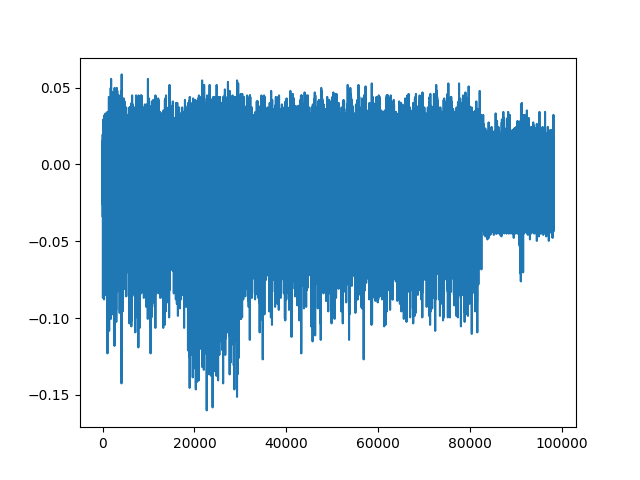

In [15]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.plot(trace.wave)
plt.show()

In [16]:

NUM_TRACES = 100

from tqdm import tnrange
import numpy as np

# capture

traces = []
for i in tnrange(NUM_TRACES, desc = 'Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    traces.append(trace)
target.dis()
scope.dis()

# convert
traces_array  = np.asarray([trace.wave for trace in traces])
textin_array  = np.asarray([trace.textin for trace in traces])
textout_array = np.asarray([trace.textout for trace in traces])
keylist_array = np.asarray([trace.key for trace in traces])

# save
from datetime import datetime
import os
now = datetime.now().strftime('%Y.%m.%d-%H.%M.%S')
os.mkdir('%s/%s'%(CUSTOM_NAME, now))
np.save('%s/%s/%s_traces'%(CUSTOM_NAME, now, now), traces_array)
np.save('%s/%s/%s_textin'%(CUSTOM_NAME, now, now), textin_array)
np.save('%s/%s/%s_textout'%(CUSTOM_NAME, now, now), textout_array)
np.save('%s/%s/%s_keylist'%(CUSTOM_NAME, now, now), keylist_array)

In [ ]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
print(traces[0].textin)
print(traces[0].textout)
print(traces[0].key)
for i in range(len(trace)):
    plt.plot(traces[i].wave)
plt.show()

In [ ]:
numTrace = 1500 # total number of traces to be analyzed
samFrom  = 2500 # initial point of interest, INCLUDED
samTo    = 6000 # final point of interest, EXCLUDED

import numpy as np

# prepare
HW = [bin(n).count("1") for n in range(0, 256)]
SBox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16]

# cut
trace = traces_array[0 : numTrace, samFrom : samTo]
p     = textin_array[0 : numTrace]
k     = keylist_array[0 : numTrace]

# analyze
samLength = samTo - samFrom
corr = []
maxC = []
for byte in tnrange(16, desc = 'Correlating with known keys'):
    hypothesis = np.zeros((numTrace, ))
    for i, im in enumerate(p[:, byte] ^ k[:, byte]):
        hypothesis[i] = HW[SBox[im]]

    c = np.zeros((samLength, ))
    for i in range(samLength):
        x = hypothesis
        y = trace[:, i]
        c[i] = abs(np.corrcoef(x, y)[0, 1])
    corr.append(c)
    maxC.append(np.max(c))

import pandas as pd
df = pd.DataFrame(maxC).transpose()
df.head()

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

for i in range(16):
    plt.plot(corr[i])
plt.show()